# Install and import dependencies

In [1]:
!pip3 install transformers
!pip3 install pytorch-pretrained-bert
!pip3 install emoji
!pip3 install ekphrasis

     |████████████████████████████████| 3.4 MB 8.3 MB/s 
     |████████████████████████████████| 895 kB 63.3 MB/s 
     |████████████████████████████████| 3.3 MB 50.5 MB/s 
     |████████████████████████████████| 61 kB 631 kB/s 
     |████████████████████████████████| 596 kB 37.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 123 kB 7.0 MB/s 
     |████████████████████████████████| 131 kB 38.1 MB/s 
     |████████████████████████████████| 8.4 MB 41.0 MB/s 
     |████████████████████████████████| 79 kB 9.6 MB/s 
     |████████████████████████████████| 138 kB 90.3 MB/s 
     |████████████████████████████████| 127 kB 68.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take int

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from pytorch_pretrained_bert.optimization import BertAdam
import sys
import random
from sklearn.model_selection import StratifiedKFold
import torch.nn.functional as F


In [3]:
# hyper parameters 
BERT_MODEL = 'bert-large-uncased'
NUM_EMO = 4
CONV_PAD_LEN = 3
EMOS = ['happy', 'angry', 'sad', 'others']
EMOS_DIC = {'happy': 0,
            'angry': 1,
            'sad': 2,
            'others': 3}

# Input pipeline

## preprocesser for processing the emoji and text

In [4]:
# input pipeline: preprocessing 

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import emoji
import string

printable = set(string.printable)

# preprocess the input text first, for their non-character like emoji 
text_processor = TextPreProcessor(
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    annotate={"repeated", "emphasis", "elongated"},
    fix_html=True,  
    segmenter="twitter",
    corrector="twitter",
    unpack_hashtags=True, 
    unpack_contractions=True, 
    spell_correct_elong=True, 
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[emoticons]
)

def processing_emoji(text):
    tokens = text.split()
    ret_list = []
    for token in tokens:
        if len(token) > 3 and '_' in token:
            token = token.replace('_', ' ')

        if token[0] == '<' and token[-1] == '>':
            token = token[1:-1]

        ret_list.append(token)
    return ' '.join(ret_list)

def preprocessing_pipeline(text):
    text = text.lower().strip()
    # text = remove_dup_emoji(text)
    text = ' '.join(text_processor.pre_process_doc(text))
    text = emoji.demojize(text, delimiters=(' ', ' '))
    text = processing_emoji(text)
    return text


def load_input(data_path='data/train.txt', is_train=True):

    data_list = []
    target_list = []

    with open(data_path, 'r') as f_data:
        data_lines = f_data.readlines()

    for i, text in enumerate(data_lines):
        # the first row is title 
        if i == 0:
            continue

        tokens = text.split('\t')

        # the first column is id
        convers = tokens[1:CONV_PAD_LEN+1]

        # 3 utterance for each x  
        a = convers[0]
        b = convers[1]
        c = convers[2]

        a = preprocessing_pipeline(a)
        b = preprocessing_pipeline(b)
        c = preprocessing_pipeline(c)


        data_list.append((a, b, c))

        #data_list.append(a + b + c)
        # glue 3 utterance together
        
        if is_train:
            emo = tokens[CONV_PAD_LEN + 1].strip()
            target_list.append(EMOS_DIC[emo])

    if is_train:
        # return x, y
        return data_list, target_list
    else:
        # return x only
        return data_list

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


## some test

In [5]:
# load data
path = 'data/train.txt'
# load train set
X, y = load_input(path)
y = np.array(y)

# shuffle input and label
combined = list(zip(X, y))
random.shuffle(combined)
X[:], y[:] = zip(*combined)

In [6]:
print(X[:10])
print(y[:10])

[('am i irritating u', 'i irk creatively', 'no issue . i will not talk to u divya anymore . bye'), ('i do mean it', 'you dont mean what ?', 'you are stupid'), ('tyaima means', 'so ? i never said yes .', 'meaning of tyaima'), ('say something intellectual', 'considering it', 'say'), ('can u suggest me gift for him', "when ' s ur birthday ?", 'number - feb'), ('what', 'sounds wonderful to me !', 'happy with my name'), ('no problem', 'thank you . relieved face', 'what is your age'), ('i miss my sister', 'i miss both of you sad', 'beaming face with smiling eyes'), ('do not test my patience . just leave .', 'do not worry even sachin also failed . ! repeated', 'you are dumb'), ('about true love', 'y dont u return to india if u say tat u " truly " love her . repeated = d', 'nice joke')]
[1 1 3 3 3 0 3 0 1 0]


## Dataloader assembler

In [7]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [8]:
def assemble_dataloader(data_list, target_list):
    # Tokenize all of the sentences and map the tokens to thier word IDs.

    input_ids = []

    # For every sentence...
    sentences = data_list

    for a,b,c in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        sent = a + b + c
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True,
                            max_length = 150,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            truncation=True,
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    labels = torch.tensor(target_list)

    # Print sentence 0, now as a list of IDs.
    #print('Original: ', sentences[0])
    #print('Token IDs:', input_ids[0])

    ### Not combine the input id , mask and labels and divide the dataset

    #:
    from torch.utils.data import TensorDataset, random_split

    # Combine the training inputs into a TensorDataset.
    dataset = TensorDataset(input_ids, labels)

    from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

    BATCH_SIZE = 32

    # Create the DataLoaders for our training sets
    dataloader = DataLoader(
                dataset,  # The training samples.
                sampler = RandomSampler(dataset), # Select batches randomly
                batch_size = BATCH_SIZE  # Trains with this batch size.
            )
    
    return dataloader

In [9]:
train_dataloader = assemble_dataloader(X, y)



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [10]:
validation_data_list, validation_target_list = load_input(data_path='data/validation.txt')
validation_dataloader = assemble_dataloader(validation_data_list, validation_target_list)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Model

## The model class

In [11]:
# the model using 

from transformers import BertModel

bert = BertModel.from_pretrained(BERT_MODEL)

class BERTLSTMSentiment(nn.Module):
    def __init__(self,bert,hidden_dim,output_dim,n_layers,bidirectional,dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']

        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            batch_first = True,
                            dropout = 0 if n_layers < 2 else dropout)
        # self.rnn = nn.GRU(embedding_dim,
        #                   hidden_dim,
        #                   num_layers = n_layers,
        #                   bidirectional = bidirectional,
        #                   batch_first = True,
        #                   dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        #_, hidden = self.rnn(embedded)
        output, (hidden, cn) = self.lstm(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## init the model object

In [12]:
HIDDEN_DIM = 128
OUTPUT_DIM = 4
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25 

model = BERTLSTMSentiment(bert,
                          HIDDEN_DIM,
                          OUTPUT_DIM,
                          N_LAYERS,
                          BIDIRECTIONAL,
                          DROPOUT)

In [13]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [14]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("total parameters is {}".format(total_params))

total parameters is 1577988


# Train

## init the loss function and optimizer

In [15]:
optimizer = optim.Adam(model.parameters())

In [16]:
criterion = nn.BCEWithLogitsLoss()

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

## define matrics, train and evaluate helper function

In [18]:
def accuracy(preds, y):
    top_pred = preds.argmax(1, keepdim = True)
    y = y.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [19]:
def train(model, dataloader, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()

    
    for (x, y) in dataloader:
        
        x = x.to(device)
        
        y = F.one_hot(y.long(), num_classes=OUTPUT_DIM)
        y = y.float().to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / (len(dataloader)), epoch_acc / (len(dataloader))

In [20]:
from sklearn.metrics import f1_score

def evaluate(model, dataloader, criterion):

    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for (x, y) in dataloader:
          
            x = x.to(device)
            y = F.one_hot(y.long(), num_classes=OUTPUT_DIM)
            y = y.float().to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / (len(dataloader)), epoch_acc / (len(dataloader))

def evaluate_f1(model, dataloader, criterion):
    
    epoch_f1 = 0
    
    model.eval()

    with torch.no_grad():
        for (x, y) in dataloader:
            x = x.to(device)
            y = F.one_hot(y.long(), num_classes=OUTPUT_DIM)
            y = y.float().to(device)
            #y = torch.argmax(y, axis=1)

            y_pred = model(x)
            y_pred = F.one_hot(torch.argmax(y_pred, axis=1))
            #y_pred = torch.argmax(y_pred, axis=1)

            epoch_f1 += f1_score(y.cpu(), y_pred.cpu(), average='micro')
        
    return epoch_f1 / (len(dataloader))

In [21]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## actually process of training

In [22]:
N_EPOCHS = 3

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time() # ...
    
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion) # ...
    valid_loss, valid_acc = evaluate(model, validation_dataloader, criterion) # ...
        
    end_time = time.time() # ...
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time) # ...

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 9m 13s
	Train Loss: 0.403 | Train Acc: 61.99%
	 Val. Loss: 0.223 |  Val. Acc: 82.61%
Epoch: 02 | Epoch Time: 9m 12s
	Train Loss: 0.248 | Train Acc: 80.05%
	 Val. Loss: 0.184 |  Val. Acc: 89.12%
Epoch: 03 | Epoch Time: 9m 12s
	Train Loss: 0.208 | Train Acc: 83.78%
	 Val. Loss: 0.164 |  Val. Acc: 86.76%


# Evaluation

## test on some simple test

In [23]:
model.load_state_dict(torch.load('model.pt'))

test_data_list, test_target_list = load_input(data_path='data/test.txt')
test_dataloader = assemble_dataloader(test_data_list, test_target_list)
test_loss, test_acc = evaluate(model, test_dataloader, criterion)
avg_f1_score = evaluate_f1(model, test_dataloader, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}')
print(f'F1_score: {avg_f1_score:.2f}')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test Loss: 0.160 | Test Acc: 0.88
F1_score: 0.88


In [24]:
print(avg_f1_score)
print(test_acc)

0.8753612716763006
0.8753612716763006


In [25]:
init_token_idx = tokenizer.convert_tokens_to_ids('[CLS]')
eos_token_idx = tokenizer.convert_tokens_to_ids('[SEP]')

def predict_sentiment(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    return prediction.cpu().detach().numpy()

In [29]:
sentence = "I feel no good for this endless lockdown bs. Me too. Hope it ends someday soon!"
res = predict_sentiment(model, tokenizer, sentence)
# EMOS = ['happy', 'angry', 'sad', 'others']
for i, emo in enumerate(EMOS):
    print(f'sentence has {res[0][i]*100:.2f}% probability to be {emo}')

sentence has 1.93% probability to be happy
sentence has 67.01% probability to be angry
sentence has 15.66% probability to be sad
sentence has 7.03% probability to be others


## draw the confusion matrix

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay

def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)

        label = y
        prob = nn.Softmax(dim=1)(y_pred)
        
        labels.append(label)
        probs.append(prob)
   
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    labels = labels.cpu().detach().numpy()
    probs = probs.cpu().detach().numpy()

    return labels, probs

def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels = classes)
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax) 
    plt.xticks(rotation = 20)

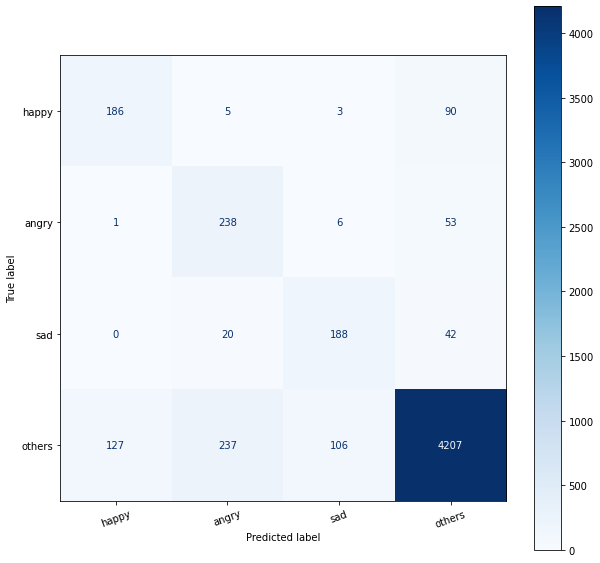

In [28]:
labels, probs = get_predictions(model, test_dataloader, device)
pred_labels = probs.argmax(1)
plot_confusion_matrix(labels, pred_labels, EMOS) 